# **Week 14: GNN**

Today class consists of three things. <br>

## **1.  We will Make Graph Convolution Equation.**
1-1. We will make graph by using networx libary. <br> 
1-2. by using Adjacency Matrix, Node index and Node embedding vector from graph, We will follow the aggregation and combination step in Graph Convolution Equation. <br>
1-3. Finally We will make GCN layer <br>

## **2.  We will make node classification in Cora dataset.**
2-1. Cora dataset Information <br>
2-2. Implement GCN model with Cora dataset <br>
2-3. Visualize node embedding

## **3.  (HOMEWORK) Run the Graph classification on the Collab Dataset**
3-1. I will introduce some brief information about the code and pytorch geometric.  <br><br>

If you have any questions, feel free to ask

*   E-Mail Address : seongjunyang@kaist.ac.kr

## **Prelims** 

pip install --user ipdb

pip install --user decorator==4.3

pip install --user networkx==2.6.1

In [1]:
import ipdb
import torch
import networkx as nx
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### **1. Make Graph Convolution Equation**

![picture](https://drive.google.com/uc?id=1BqgZ_3xUQ7ScvoPVHUZbx5o4xBGSlLVS)

#### **1) Initialize the Graph G**
By using networkx library, you can do research in graph or network easily. <br>
So, in the Graph Convolution Equation, I'll use networkx libary. 

In [2]:
#1. Initialize the graph
G = nx.Graph(name='G')

In [3]:
#2. Create nodes
#In this class, we will make graph that consist of 6 nodes.
#Each node is assigned node feature which corresponds to the node name
for i in range(1,7):
    G.add_node(i, name=i)

In [4]:
#Define the edges and the edges to the graph
edges = [(1,2), (1,3), (2,4), (2,5), (3,4), (3,6) ]
G.add_edges_from(edges)

In [5]:
#See graph info
print('Graph Info:\n', nx.info(G))

Graph Info:
 Name: G
Type: Graph
Number of nodes: 6
Number of edges: 6
Average degree:   2.0000


In [6]:
#Inspect the node features
print('\nGraph Nodes: ', G.nodes.data())


Graph Nodes:  [(1, {'name': 1}), (2, {'name': 2}), (3, {'name': 3}), (4, {'name': 4}), (5, {'name': 5}), (6, {'name': 6})]


#### Inserting Adjacency Matrix to forward pass 

In [10]:
nx.attr_matrix(G, node_attr='name')

(matrix([[0., 1., 1., 0., 0., 0.],
         [1., 0., 0., 1., 1., 0.],
         [1., 0., 0., 1., 0., 1.],
         [0., 1., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.]]),
 [1, 2, 3, 4, 5, 6])

In [12]:
#Get the Adjacency Matrix (A) and Node Features Matrix (X) as numpy array
A = np.array(nx.attr_matrix(G, node_attr='name')[0]) # Converting for getting numpy Adjacency Matrix (A)
X = np.array(nx.attr_matrix(G, node_attr='name')[1]) # Converting for getting numpy Node Features Matrix (X)
X = np.expand_dims(X,axis=1) # Make [6, 1] numpy Node Features Matrix (X)

In [13]:
print('Shape of A: ', A.shape) # [6, 6] matrix

Shape of A:  (6, 6)


In [14]:
print('\nShape of X: ', X.shape) # [6, 1] matrix


Shape of X:  (6, 1)


In [15]:
print('\nAdjacency Matrix (A):\n', A)


Adjacency Matrix (A):
 [[0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [16]:
print('\nNode Features Matrix (X):\n', X)


Node Features Matrix (X):
 [[1]
 [2]
 [3]
 [4]
 [5]
 [6]]


In [17]:
#Dot product Adjacency Matrix (A) and Node Features (X)
AX = np.dot(A,X) # AX
print("Dot product of A and X (AX):\n", AX)

Dot product of A and X (AX):
 [[ 5.]
 [10.]
 [11.]
 [ 5.]
 [ 2.]
 [ 3.]]


##### **Question : Is this the node representations H?**
##### No, A*X is just neighbor aggregation.
##### **We need the combination step!**

#### **Add Self-Loops and Normalize Adjacency Matrix (A)**
**A' = A + I**

In [18]:
#Add Self Loops
G_self_loops = G.copy() # A'

self_loops = []
for i in range(1, 1+ G.number_of_nodes()):
    self_loops.append((i,i))

G_self_loops.add_edges_from(self_loops) # A' = A + I


In [19]:
#Check the edges of G_self_loops after adding the self loops
print('Edges of G with self-loops:\n', G_self_loops.edges)

Edges of G with self-loops:
 [(1, 2), (1, 3), (1, 1), (2, 4), (2, 5), (2, 2), (3, 4), (3, 6), (3, 3), (4, 4), (5, 5), (6, 6)]


In [20]:
#Get the Adjacency Matrix (A) and Node Features Matrix (X) of added self-lopps graph
A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0]) # A' numpy Matrix
print('Adjacency Matrix of added self-loops G (A_hat):\n', A_hat)

Adjacency Matrix of added self-loops G (A_hat):
 [[1. 1. 1. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 1. 0. 1.]
 [0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1.]]


##### **A' * X Matrix**

In [21]:
#Calculate the dot product of A_hat and X (AX)
A_hatX = np.dot(A_hat, X)
print('A_hatX:\n', A_hatX)

A_hatX:
 [[ 6.]
 [12.]
 [14.]
 [ 9.]
 [ 7.]
 [ 9.]]


##### But, there is another problem.
##### Scales of node features differ by the number of neighbors.
##### Solution : Normalization by inverse degree matrix.
##### **D_inverse * A'**

In [22]:
#Get the Degree Matrix of the added self-loops graph # 몇개씩 연결되어있는지 연산
edge_List = G_self_loops.edges() 
Deg_Mat = [[i, 0] for i in G_self_loops.nodes()]

for element in edge_List:
  if element[0] != element[1]:
    Deg_Mat[element[0] - 1][1] += 1
    Deg_Mat[element[1] - 1][1] += 1
  else :
    Deg_Mat[element[0] - 1][1] += 1

print(Deg_Mat)

[[1, 3], [2, 4], [3, 4], [4, 3], [5, 2], [6, 2]]


In [23]:
edge_List

EdgeView([(1, 2), (1, 3), (1, 1), (2, 4), (2, 5), (2, 2), (3, 4), (3, 6), (3, 3), (4, 4), (5, 5), (6, 6)])

In [25]:
G_self_loops.nodes()

NodeView((1, 2, 3, 4, 5, 6))

In [24]:
Deg_Mat

[[1, 3], [2, 4], [3, 4], [4, 3], [5, 2], [6, 2]]

In [26]:
#Convert the Degree Matrix to a N x N matrix where N is the number of nodes
D = np.diag([deg for [n,deg] in Deg_Mat]) # Get degree matrix

print('Degree Matrix of added self-loops G as numpy array (D):\n', D)

Degree Matrix of added self-loops G as numpy array (D):
 [[3 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 2 0]
 [0 0 0 0 0 2]]


##### **D_inverse**

In [27]:
#Get the inverse of Degree Matrix (D)
D_inv = np.linalg.inv(D)
print('Inverse of D:\n', D_inv)

Inverse of D:
 [[ 0.33333333  0.          0.          0.          0.          0.        ]
 [ 0.          0.25        0.          0.          0.          0.        ]
 [ 0.          0.          0.25        0.          0.          0.        ]
 [-0.         -0.         -0.          0.33333333 -0.         -0.        ]
 [ 0.          0.          0.          0.          0.5         0.        ]
 [ 0.          0.          0.          0.          0.          0.5       ]]


##### **D_inverse*A'**

In [28]:
D_invA = np.dot(D_inv, A_hat)
print(D_invA)

[[0.33333333 0.33333333 0.33333333 0.         0.         0.        ]
 [0.25       0.25       0.         0.25       0.25       0.        ]
 [0.25       0.         0.25       0.25       0.         0.25      ]
 [0.         0.33333333 0.33333333 0.33333333 0.         0.        ]
 [0.         0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.5        0.         0.         0.5       ]]


##### **D_invA'X**

In [29]:
#Dot product of D and AX for normalization
DAX = np.dot(D_invA,X)

print('DAXW:\n', DAX)

DAXW:
 [[2. ]
 [3. ]
 [3.5]
 [3. ]
 [3.5]
 [4.5]]


#### **Add Weights and Activation Function**

In [30]:
#Initialize the weights
np.random.seed(12345)
n_h = 4 #number of neurons in the hidden layer
n_y = 2 #number of neurons in the output layer
W0 = np.random.randn(X.shape[1],n_h) * 0.01
W1 = np.random.randn(n_h,n_y) * 0.01

print('W0 weight:\n', W0)
print('W1 weight:\n', W1)

W0 weight:
 [[-0.00204708  0.00478943 -0.00519439 -0.0055573 ]]
W1 weight:
 [[ 0.01965781  0.01393406]
 [ 0.00092908  0.00281746]
 [ 0.00769023  0.01246435]
 [ 0.01007189 -0.01296221]]


#### **GCN Layer**
##### **TODO : fill ????? with proper code and run**

In [31]:
#Implement ReLu as activation function,
#Originally, non-linear activation needed, but when I searched some material, relu is used for activate function generally.
def relu(x):
    return np.maximum(0,x)

#Build GCN layer
#In this function, we implement numpy to simplify
def gcn(A,H,W):
    #ipdb.set_trace()
    I = np.identity(A.shape[0])
    A_hat = A + I
    D = np.diag(np.sum(A_hat, axis = 0))
    D_inv = np.linalg.inv(D)
    D_invA = np.dot(D_inv, A_hat)
    DAXW = np.dot(D_invA,H).dot(W)
    return relu(DAXW)

In [33]:
#Do forward propagation
H1 = gcn(A,X,W0) # Make GCN layer
H2 = gcn(A,H1,W1) # Make GCN layer
print('Node Embedding from GCN output:\n', H2)

Node Embedding from GCN output:
 [[1.26076558e-05 3.82331255e-05]
 [1.27930625e-05 3.87953773e-05]
 [1.44617228e-05 4.38556439e-05]
 [1.40909094e-05 4.27311403e-05]
 [1.44617228e-05 4.38556439e-05]
 [1.77990434e-05 5.39761772e-05]]


#### **Plotting Node Embedding**

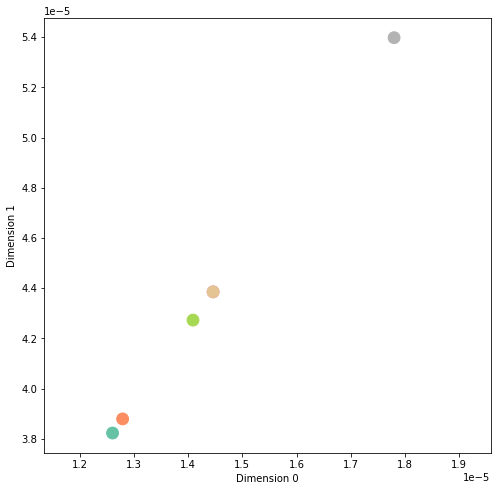

In [34]:
def visualize(h, color):
    plt.figure(figsize=(8, 8))
    plt.xlim([np.min(h[:,0])*0.9, np.max(h[:,0])*1.1])
    plt.xlabel('Dimension 0')
    plt.ylabel('Dimension 1')

    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    plt.show()

visualize(H2, color=range(6)) # node3 and node 5 have same embedding, So Two nodes overlap on the screen.

## **2. Node classification on Cora Dataset**

### **Prelims**

In [35]:
import math
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.optim as optim
import time

### **Cora Dataset**
Dataset link : https://relational.fit.cvut.cz/dataset/CORA <br>
The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. <br>

!wget https://www.dropbox.com/s/fl9mvrio3hah4on/cora.content
!wget https://www.dropbox.com/s/l829sldp7xqrt0h/cora.cites

In [37]:
import pandas as pd
import os

edgelist = pd.read_csv("../../../data/ai504/cora.cites", sep='\t', header=None, names=["target", "source"]) # it has graph
edgelist["label"] = "cites"
edgelist.sample(frac=1).head(5) # <ID of cited paper node> <ID of citing paper node>, by doing this, you can see the edge information

,target,source,label
4294,152731,1109392,cites
2625,28385,118558,cites
4255,144408,219446,cites
3696,78555,78557,cites
437,1365,188318,cites


In [42]:
# 노드 index list를 가져올 수 있게 됨
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")

# print(Gnx.nodes) # from edgelist, by using from_pandas_edgelist() function, we can extract node list from edgelist
# Gnx.nodes[12210] ## by type this, we can see the node feature

In [44]:
feature_names = ["word_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv("../../../data/ai504/cora.content", sep='\t', header=None, names=column_names)
node_data.head(5) # <paper node id> <word_attributes>+ <node label>

# 여기에는 node index별로 node occurancy table을 가져올 수 있음

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_1424,word_1425,word_1426,word_1427,word_1428,word_1429,word_1430,word_1431,word_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [45]:
# 7가지 subject 에 대한 정보로, target 임
set(node_data["subject"]) # node class type

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In the class, we will predict the subject of a paper (node) on the basis of the surrounding node data and the structure of the graph.

### **Hyperparameter**

In [48]:
EPOCH = 200
SEED = 42
NUM_HIDDEN = 16
dropout_rate = 0.5
learning_rate = 0.01
weight_decay = 5e-4

### **Preprocess and Make Dataset**

In [49]:
# Class를 One-hot으로 바꿈
def encode_onehot(labels): # we will make all class(subject) to one-hot vector for training.
    classes = set(labels) # {'Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory'}
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot

In [51]:
def normalize(mx): # This part is similar to the normalization process implemented earlier.
    #ipdb.set_trace()
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [52]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx): # Convert a scipy sparse matrix to a torch sparse tensor.
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [71]:
def load_data(path="../../../data/ai504/", dataset="cora"):
    # In the function, by using above 3 function, 
    print('Loading {} dataset...'.format(dataset))

    #ipdb.set_trace()
    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str)) # load all tables
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)  # Compress sparse matrix
    labels = encode_onehot(idx_features_labels[:, -1]) # Label onehot encoding

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32) # node list
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)

    # build adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    # split all nodes to train/valid/test for node classification
    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

In [72]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

#### **Model Architecture**
##### **TODO : Fill ????? with proper code and Run**

In [73]:
class GraphConvolution(Module):
    
    #Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        # initialize weight by using reset_parameters() function
        self.in_features = in_features 
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        return output

In [74]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
      # Obtain Node embedding
      #ipdb.set_trace()
      # Make forward propagation by referencing Section 1 (Graph Convolution Equation's forward propagation).

      x = self.gc1(x, adj)
      x = F.relu(x)
      x = F.dropout(x, self.dropout, training= self.training)
      x = self.gc2(x,adj)
      x = F.log_softmax(x, dim = 1)
      return x


#### **Setting for training model**

In [75]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [76]:
%%time

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data() # adj -> adjacency matrix, same ax A,   features -> node feature matrix, same as X

Loading cora dataset...
Wall time: 3.84 s


In [77]:
# Model and optimizer
model = GCN(nfeat=features.shape[1], # [2708, 1433] -> [1433] for matrix multiplication of X and W
            nhid=NUM_HIDDEN,
            nclass=labels.max().item() + 1,
            dropout=dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [78]:
model.cuda()
features = features.cuda()
adj = adj.cuda()
labels = labels.cuda()
idx_train = idx_train.cuda()
idx_val = idx_val.cuda()
idx_test = idx_test.cuda()

### **Train code**
In the train() function, We train GCN by using nll_loss objective function and Adam Optimizer. <br>
By using train and validation index, We get output in model result.

In [79]:
def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()

    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    # Evaluate validation set performance separately,
    # deactivates dropout during validation run.
    model.eval()
    output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])

    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()))

### **Test code**
In the test() function, we test trained model with node embedding visualization (T-SNE).

In [88]:
model.eval()

GCN(
  (gc1): GraphConvolution()
  (gc2): GraphConvolution()
)

In [86]:
# Visualize
def visualize(h, label, idx):
    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Dimension 0')
    plt.ylabel('Dimension 1')

    h_ = h[idx]
    color = [ label[i] for i in idx ]
    print(f'Embedding shape: {list(h_.shape)}')
    z = TSNE(n_components=2).fit_transform(h_.cpu().detach().numpy())  
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def test(): # get loss and accuracy with node embedding visualization
    model.eval()
    output = model(features, adj)
    visualize(output, labels, idx_test)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

### **Train**
When I measure time for traing, About 1.35 sec

In [84]:
%%time

# Train model
t_total = time.time()
for epoch in range(EPOCH):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 0001 loss_train: 0.3813 acc_train: 0.9500 loss_val: 0.7097 acc_val: 0.8067
Epoch: 0002 loss_train: 0.3507 acc_train: 0.9571 loss_val: 0.7082 acc_val: 0.8067
Epoch: 0003 loss_train: 0.3458 acc_train: 0.9429 loss_val: 0.7067 acc_val: 0.8133
Epoch: 0004 loss_train: 0.3947 acc_train: 0.9500 loss_val: 0.7057 acc_val: 0.8133
Epoch: 0005 loss_train: 0.3766 acc_train: 0.9429 loss_val: 0.7049 acc_val: 0.8133
Epoch: 0006 loss_train: 0.3471 acc_train: 0.9571 loss_val: 0.7045 acc_val: 0.8133
Epoch: 0007 loss_train: 0.3804 acc_train: 0.9429 loss_val: 0.7032 acc_val: 0.8133
Epoch: 0008 loss_train: 0.3766 acc_train: 0.9429 loss_val: 0.7018 acc_val: 0.8133
Epoch: 0009 loss_train: 0.3657 acc_train: 0.9571 loss_val: 0.7003 acc_val: 0.8133
Epoch: 0010 loss_train: 0.3789 acc_train: 0.9571 loss_val: 0.6982 acc_val: 0.8100
Epoch: 0011 loss_train: 0.3795 acc_train: 0.9429 loss_val: 0.6964 acc_val: 0.8100
Epoch: 0012 loss_train: 0.3521 acc_train: 0.9643 loss_val: 0.6949 acc_val: 0.8100
Epoch: 0013 loss

### **Test**
When I measure test time, About 6.79 sec

Embedding shape: [1000, 7]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

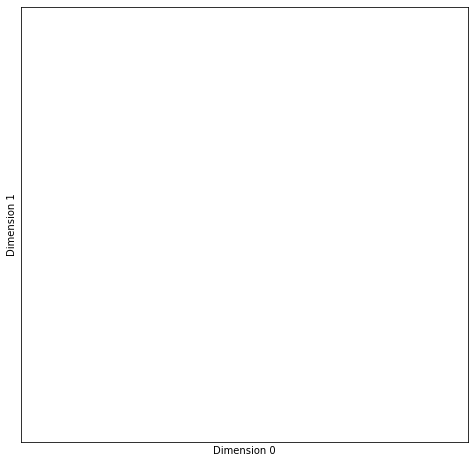

In [87]:
%%time

# Testing
test()

## **3. (HOMEWORK) Graph Classification on Collab Dataset**

**Collab Dataset** <br>
it is a large dataset containing many graphs and graph labels. <br>
This dataset is mainly used for graph classification.<br> <br>

The code is made on pytorch_geometric library. <br>
**Why do I use?** <br>
pytorch_geometric is very fast despite working on sparse data. Compared to the Deep GraphLibrary (DGL) 0.1.3, pytorch_geometric trains models up to 15 times faster. <br>

![picture](https://drive.google.com/uc?id=13jMho-M4Em8B32HzNWkXpnUcA4QGyXYU)

So, I recommend running the code and studying the library. <br><br>

Reference : https://medium.com/syncedreview/pytorch-geometric-a-fast-pytorch-library-for-dl-a833dff466e5



### **Prem**

In [ ]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch-geometric

In [ ]:
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
from torch_geometric.utils import degree

In [ ]:
%%time

def create_one_hot_transform(dataset): # Since the collab dataset does not have a node feature, So I make a node feature using the max_degree value.
    max_degree = 0                     # I reference that in https://paperswithcode.com/sota/graph-classification-on-collab.
    degs = []
    for data in dataset:
        degs += [degree(data.edge_index[0], dtype=torch.long)]
        max_degree = max(max_degree, degs[-1].max().item())

    return T.OneHotDegree(max_degree)

def load_dataset():
        dataset = TUDataset(root='/tmp/COLLAB', name="COLLAB")
        dataset.transform = create_one_hot_transform(dataset)
        return dataset

dataset = load_dataset()

In [ ]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of features: {dataset.num_features}')



###### One graph #####
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

In [ ]:
# One graph edges
print(data.edge_index)

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

#It shows one graph of Collab dataset.
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True, cmap="Set2", width=0.5, node_size=500, node_color='yellow')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
torch.manual_seed(12345)
dataset = dataset.shuffle() # Label data are sequentially located. (0, 1, 2)

# train / valid
train_dataset = dataset[:4000]
valid_dataset = dataset[4000:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(valid_dataset)}')

In [ ]:
from torch_geometric.data import DataLoader

# Unlike CV and NLP, in graph, DataLoader aggregates node_feature, weight and edge_index from different samples/ graphs into Batches
# So The GNN model needs this “batch” information to know which nodes belong to the same graph within a batch to perform computation. 
# Reference : https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8
# Reference : https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels) # When I used one more GCNConv, the performance came out better.
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        #ipdb.set_trace()
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels] , for graph classsification
        h = x.clone().detach() # for making graph embedding        

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x , h

In [ ]:
model = GCN(hidden_channels=64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(epoch=None):
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
         data = data.to(device)
         out, _ = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
    
    print(f'Epoch: {epoch:03d}, Train loss: {loss:.4f}')
         

def test(loader, visual=False):
  model.eval()
  
  correct = 0
  for data in loader:  # Iterate in batches over the training/test dataset.
    data = data.to(device)
    out, h = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    
    if visual == True:
      colors = ['#3A3120', '#535D8E', '#BD3430']
      color = [ colors[i] for i in data.y.detach().cpu()]
      z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
      
      plt.figure(figsize=(10,10))
      plt.xticks([])
      plt.yticks([])
      print(f'Embedding shape: {list(h.shape)}')
      plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
      plt.show()

  return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [ ]:
%%time
################################
for epoch in range(1, 31):
    train(epoch)
    test_acc = test(valid_loader)
    if epoch % 5 == 0:
      print(f'Epoch: {epoch:03d}, Test Acc: {test_acc:.4f}')

In [ ]:
### When you run the code, uncomment below command.
#test(valid_loader, visual=True) # t-SNE

## **Reference**
Thomas N. Kipf, Max Welling, Semi-Supervised Classification with Graph Convolutional Networks (ICLR 2017) <br>
http://tkipf.github.io/graph-convolutional-networks/ <br>
https://relational.fit.cvut.cz/dataset/CORA <br>
https://paperswithcode.com/sota/graph-classification-on-collab <br>
https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html <br>
https://medium.com/syncedreview/pytorch-geometric-a-fast-pytorch-library-for-dl-a833dff466e5 <br>
https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8 <br>
https://paperswithcode.com/sota/node-classification-on-cora <br>
https://graphsandnetworks.com/the-cora-dataset/ <br>
https://github.com/tkipf/pygcn <br>
https://pytorch-geometric.readthedocs.io/en/latest/ <br>
https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing <br>
http://networkrepository.com/COLLAB.php <br>